In [1]:
import numpy as np
from scipy import stats
import pandas as pd
import statsmodels.api as sm
import matplotlib.pylab as plt
from tabulate import tabulate
import seaborn as sns

%matplotlib inline
from sklearn.linear_model import LogisticRegression
from google.colab import drive
#mounting my google driving to access data
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
df = pd.read_csv('/content/drive/MyDrive/Second Year Project/Student Data /Logistic_Data_LA_Level_DFW.csv')
df2 = pd.read_csv('/content/drive/MyDrive/Second Year Project/Student Data /Logistic_Data_UP_SYG.csv')



<ipython-input-2-ccd35002f1a9>:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/Second Year Project/Student Data /Logistic_Data_LA_Level_DFW.csv')


Below I am narrowinf down the DFW data to only look at UP1 nad UP2

In [3]:
df = df[(df['subject'] == 'PHYS') & ((df['catalog_nbr'] == '211') | (df['catalog_nbr'] == '212'))]
df = df[~(df['section Type'] == 'LAB')]
df = df[(df['class_section'] != '600') & (df['class_section'] != '601')]
df = df[df['Term'] <= 2195]

In [4]:
df['LA Count'].value_counts()

LA Count
0    7811
1     829
2     219
3      63
4       8
6       5
5       5
7       1
Name: count, dtype: int64

In [5]:
#making a few new data features with AALANA students for the DFW data


df['AALANA with LA'] = 0
df.loc[(df['AALANA dummy'] == 1) & (df['LA'] == 1), 'AALANA with LA'] = 1

df['AALANA with LA Count'] = 0
df.loc[(df['AALANA dummy'] == 1) & (df['LA Count'] == 1), 'AALANA with LA Count'] = 1

df['AALANA with no LA'] = 0
df.loc[(df['AALANA dummy'] == 1) & (df['LA'] == 0), 'AALANA with no LA'] = 1

df['AALANA with no LA Count'] = 0
df.loc[(df['AALANA dummy'] == 1) & (df['LA Count'] == 0), 'AALANA with no LA Count'] = 1

df['Non-AALANA with LA'] = 0
df.loc[(df['AALANA dummy'] == 0) & (df['LA'] == 1), 'Non-AALANA with LA'] = 1

df['Non-AALANA with LA Count'] = 0
df.loc[(df['AALANA dummy'] == 0) & (df['LA Count'] == 1), 'Non-AALANA with LA Count'] = 1

df['Non-AALANA with no LA'] = 0
df.loc[(df['AALANA dummy'] == 0) & (df['LA'] == 0), 'Non-AALANA with no LA'] = 1

df['Non-AALANA with no LA Count'] = 0
df.loc[(df['AALANA dummy'] == 0) & (df['LA Count'] == 0), 'Non-AALANA with no LA Count'] = 1



#double checking the values counts For the different AALANA groups
print(df['AALANA with LA'].value_counts())
print(df['AALANA with LA Count'].value_counts())
print(df['AALANA with no LA'].value_counts())
print(df['AALANA with no LA Count'].value_counts())
print(df['Non-AALANA with LA'].value_counts())
print(df['Non-AALANA with LA Count'].value_counts())
print(df['Non-AALANA with no LA'].value_counts())
print(df['Non-AALANA with no LA Count'].value_counts())

AALANA with LA
0    8659
1     282
Name: count, dtype: int64
AALANA with LA Count
0    8858
1      83
Name: count, dtype: int64
AALANA with no LA
0    8405
1     536
Name: count, dtype: int64
AALANA with no LA Count
0    8253
1     688
Name: count, dtype: int64
Non-AALANA with LA
0    6122
1    2819
Name: count, dtype: int64
Non-AALANA with LA Count
0    8195
1     746
Name: count, dtype: int64
Non-AALANA with no LA
1    5304
0    3637
Name: count, dtype: int64
Non-AALANA with no LA Count
1    7123
0    1818
Name: count, dtype: int64


In [6]:
#calculate DFW rate (for UP) for AALANA and non-AALANA students who have and have not had LA


# SYG Rate for AALANA who have had  an LA in UP
(df['SYG'] == 1)
(df['AALANA dummy'] == 1)
(df['AALANA dummy'] == 0)
(df['LA'] == 1)
(df['LA'] == 0)


# DFW Rate for AALANA who have had  an LA in UP
numerator1 = ((df['AALANA dummy'] == 1) & (df['LA'] == 1) & (df['DFW dummy'] == 1))
denominator1 = ((df['AALANA dummy'] == 1) & (df['LA'] == 1))
ratio = sum(numerator1) /sum(denominator1)
print(f'DFW Rate for AALANA who have had an LA in UP: {ratio}')


#DFW Rate for AALANA who did not have an LA in UP
numerator3 = ((df['AALANA dummy'] == 1) & (df['LA'] == 0) & (df['DFW dummy'] == 1))
denominator3 = ((df['AALANA dummy'] == 1) & (df['LA'] == 0))
ratio = sum(numerator3) /sum(denominator3)
print(f'DFW Rate for AALANA who did not have an LA in UP: {ratio}')

# DFW Rate for Non AALANA who have had an LA in UP
numerator2 = ((df['AALANA dummy'] == 0) & (df['LA'] == 1) & (df['DFW dummy'] == 1))
denominator2 = ((df['AALANA dummy'] == 0) & (df['LA'] == 1))
ratio = sum(numerator2) /sum(denominator2)
print(f'DFW Rate for Non AALANA who have had an LA in UP: {ratio}')



#DFW Rate for Non AALANA who did not have an LA in UP
numerator4 = ((df['AALANA dummy'] == 0) & (df['LA'] == 0) & (df['DFW dummy'] == 1))
denominator4 = ((df['AALANA dummy'] == 0) & (df['LA'] == 0))
ratio = sum(numerator4) /sum(denominator4)
print(f'DFW Rate for Non AALANA who did not have an LA in UP: {ratio}')



DFW Rate for AALANA who have had an LA in UP: 0.2872340425531915
DFW Rate for AALANA who did not have an LA in UP: 0.3880597014925373
DFW Rate for Non AALANA who have had an LA in UP: 0.17594891805604823
DFW Rate for Non AALANA who did not have an LA in UP: 0.2441553544494721


In [7]:
from statsmodels.stats.proportion import proportion_confint

filtered_df = df.groupby('ID').filter(lambda x: 211 in x['catalog_nbr'].values and 212 in x['catalog_nbr'].values)

# filtered_df1 = filtered_df[(filtered_df['catalog_nbr'] == 212) & (filtered_df['ID'].isin(filtered_df[(filtered_df['catalog_nbr'] == 211) & (filtered_df['LA'] == 1)]['ID']))]
# filtered_df2 = filtered_df[(filtered_df['catalog_nbr'] == 212) & (filtered_df['ID'].isin(filtered_df[(filtered_df['catalog_nbr'] == 211) & (filtered_df['LA'] == 0)]['ID']))]


filtered_df1a = filtered_df[filtered_df['UP2 LA Only']==1]
filtered_df1 = filtered_df1a[filtered_df1a['catalog_nbr'] == 212]

filtered_df2a = filtered_df[filtered_df['UP1&2 LA']==1]
filtered_df2 = filtered_df2a[filtered_df2a['catalog_nbr'] == 212]


print('Had an LA in UP1:', len(filtered_df1[filtered_df1['DFW dummy'] == 1]) / len(filtered_df1))
print('Did not have an LA in UP1:', len(filtered_df2[filtered_df2['DFW dummy'] == 1]) / len(filtered_df2))

# Calculate proportions
prop_df1 = len(filtered_df1[filtered_df1['DFW dummy'] == 1]) / len(filtered_df1)
prop_df2 = len(filtered_df2[filtered_df2['DFW dummy'] == 1]) / len(filtered_df2)

# Calculate confidence intervals for proportions
ci_df1 = proportion_confint(sum(filtered_df1['DFW dummy']), len(filtered_df1), method='normal', alpha=0.5)
ci_df2 = proportion_confint(sum(filtered_df2['DFW dummy']), len(filtered_df2), method='normal', alpha=0.4)

# Calculate midpoint of confidence intervals
midpoint_df1 = np.mean(ci_df1)
midpoint_df2 = np.mean(ci_df2)

# Calculate half-width of confidence intervals
halfwidth_df1 = (ci_df1[1] - ci_df1[0]) / 2
halfwidth_df2 = (ci_df2[1] - ci_df2[0]) / 2

# Plotting
plt.figure(figsize=(6, 5))  # Adjust the figure size here

# Plot values with error bars for 'Had an LA in UP1'
plt.errorbar(0.5, prop_df1, yerr=halfwidth_df1, fmt='o', color='blue', alpha=0.7, label='Had an LA in UP1', markersize=14, linewidth=3)  # Center position for the first histogram

# Plot values with error bars for 'Did not have an LA in UP1'
plt.errorbar(1.5, prop_df2, yerr=halfwidth_df2, fmt='o', color='blue', alpha=0.7, label='Did not have an LA in UP1', markersize=14, linewidth=3)  # Center position for the second histogram

# Plot small horizontal lines for confidence intervals on the first histogram
plt.plot([0.45, 0.55], [ci_df1[1], ci_df1[1]], color='blue', linestyle='solid', linewidth=3)  # Upper limit of CI for filtered_df1
plt.plot([0.45, 0.55], [ci_df1[0], ci_df1[0]], color='blue', linestyle='solid', linewidth=3)  # Lower limit of CI for filtered_df1

# Plot small horizontal lines for confidence intervals on the second histogram
plt.plot([1.45, 1.55], [ci_df2[1], ci_df2[1]], color='blue', linestyle='solid', linewidth=3)  # Upper limit of CI for filtered_df2
plt.plot([1.45, 1.55], [ci_df2[0], ci_df2[0]], color='blue', linestyle='solid', linewidth=3)  # Lower limit of CI for filtered_df2

# Labeling with adjusted font sizes
plt.ylabel('UP2 DFW \n Rate', fontsize=20, rotation=0, labelpad=57)  # Horizontal y-axis label with line break
plt.yticks(fontsize=18)  # Adjust font size of y-axis ticks

# Adjust the x ticks
plt.xticks([0.5, 1.5], ['LA in UP1', 'No LA in UP1'], fontsize=20)

# Set the x-axis limits to reduce white space
plt.xlim(0, 2)

# Add grid
plt.grid(True)

# Show plot
plt.show()


ZeroDivisionError: division by zero

In [8]:
#calculate SYGR and DFW rate (for UP1&2) for AALANA and non-AALANA students who have and have not had LA


# SYG Rate for AALANA who have had  an LA in UP1&2
(df2['SYG'] == 1)
(df2['AALANA dummy'] == 1)
(df2['AALANA dummy'] == 0)
(df2['LA'] == 1)
(df2['LA'] == 0)


# SYG Rate for AALANA who have had  an LA in UP1&2
numerator1 = ((df2['AALANA dummy'] == 1) & (df2['LA'] == 1) & (df2['SYG'] == 1))
denominator1 = ((df2['AALANA dummy'] == 1) & (df2['LA'] == 1))
ratio = sum(numerator1) /sum(denominator1)
print(f'SYG Rate for AALANA who have had an LA in UP: {ratio}')


#SYG Rate for AALANA who did not have an LA in UP
numerator3 = ((df2['AALANA dummy'] == 1) & (df2['LA'] == 0) & (df2['SYG'] == 1))
denominator3 = ((df2['AALANA dummy'] == 1) & (df2['LA'] == 0))
ratio = sum(numerator3) /sum(denominator3)
print(f'SYG Rate for AALANA who did not have an LA in UP: {ratio}')



# SYG Rate for Non AALANA who have had an LA in UP
numerator2 = ((df2['AALANA dummy'] == 0) & (df2['LA'] == 1) & (df2['SYG'] == 1))
denominator2 = ((df2['AALANA dummy'] == 0) & (df2['LA'] == 1))
ratio = sum(numerator2) /sum(denominator2)
print(f'SYG Rate for Non AALANA who have had an LA in UP: {ratio}')




#SYG Rate for Non AALANA who did not have an LA in UP
numerator4 = ((df2['AALANA dummy'] == 0) & (df2['LA'] == 0) & (df2['SYG'] == 1))
denominator4 = ((df2['AALANA dummy'] == 0) & (df2['LA'] == 0))
ratio = sum(numerator4) /sum(denominator4)
print(f'SYG Rate for Non AALANA who did not have an LA in UP: {ratio}')





SYG Rate for AALANA who have had an LA in UP: 0.8134328358208955
SYG Rate for AALANA who did not have an LA in UP: 0.8207885304659498
SYG Rate for Non AALANA who have had an LA in UP: 0.8499308437067773
SYG Rate for Non AALANA who did not have an LA in UP: 0.8468930172966047


In [9]:
#making a few new data features with AALANA students for the SYG data


df2['AALANA with LA'] = 0
df2.loc[(df2['AALANA dummy'] == 1) & (df2['LA'] == 1), 'AALANA with LA'] = 1

df2['AALANA with no LA'] = 0
df2.loc[(df2['AALANA dummy'] == 1) & (df2['LA'] == 0), 'AALANA with no LA'] = 1

df2['Non-AALANA with LA'] = 0
df2.loc[(df2['AALANA dummy'] == 0) & (df2['LA'] == 1), 'Non-AALANA with LA'] = 1

df2['Non-AALANA with no LA'] = 0
df2.loc[(df2['AALANA dummy'] == 0) & (df2['LA'] == 0), 'Non-AALANA with no LA'] = 1



#double checking the values counts For the different AALANA groups
print(df2['AALANA with LA'].value_counts())
print(df2['AALANA with no LA'].value_counts())
print(df2['Non-AALANA with LA'].value_counts())
print(df2['Non-AALANA with no LA'].value_counts())

AALANA with LA
0    4847
1     134
Name: count, dtype: int64
AALANA with no LA
0    4702
1     279
Name: count, dtype: int64
Non-AALANA with LA
0    3535
1    1446
Name: count, dtype: int64
Non-AALANA with no LA
1    3122
0    1859
Name: count, dtype: int64


In [10]:
df['LA Count'].value_counts()

LA Count
0    7811
1     829
2     219
3      63
4       8
6       5
5       5
7       1
Name: count, dtype: int64

In [11]:

Xtrain = df[['LA', 'LA Count', 'gender dummy', 'First Gen dummy', 'AALANA dummy']]
ytrain_DFW = df['DFW dummy']

log_reg_With_DFW = sm.Logit(ytrain_DFW, Xtrain).fit()
# printing the summary table
print(log_reg_With_DFW.summary())

Optimization terminated successfully.
         Current function value: 0.600595
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:              DFW dummy   No. Observations:                 8941
Model:                          Logit   Df Residuals:                     8936
Method:                           MLE   Df Model:                            4
Date:                Wed, 24 Jul 2024   Pseudo R-squ.:                 -0.1072
Time:                        21:46:28   Log-Likelihood:                -5369.9
converged:                       True   LL-Null:                       -4850.0
Covariance Type:            nonrobust   LLR p-value:                     1.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
LA                 -1.2384      0.050    -25.001      0.000      -1.336      -1.141
LA Count      

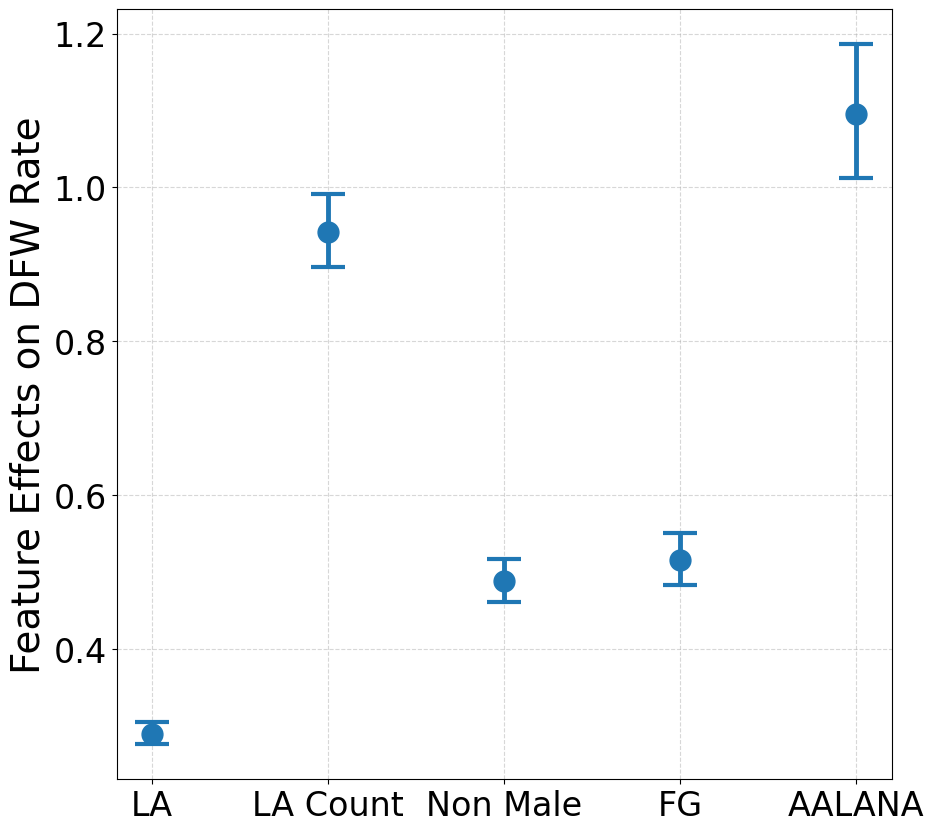

In [16]:
import seaborn as sns

# Sample data (replace this with your data)
exp_coefficients_DFW = np.exp(log_reg_With_DFW.params)
coefficients = log_reg_With_DFW.params.values
std_errors = log_reg_With_DFW.bse.values

# Calculate upper and lower bounds of error bars
error_range = np.exp(std_errors)  # raise to the power of e
upper_bound = np.exp(coefficients + std_errors)
lower_bound = np.exp(coefficients - std_errors)

# Colorblind-friendly palette
colors = sns.color_palette('colorblind', n_colors=len(features))


# Features (replace this with your feature names)
features = ['LA','LA Count', 'Non Male', 'FG', 'AALANA']

# Create a scatter plot with error bars
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust width and height as needed

# Plot coefficient values as dots
dots = ax.errorbar(np.arange(len(features)), exp_coefficients_DFW, yerr=[exp_coefficients_DFW - lower_bound, upper_bound - exp_coefficients_DFW], fmt='o', markersize=15, color='tab:blue', ecolor='tab:blue', capsize=12, capthick=3, linewidth=3.5)  # Adjust capthick here

# Customize the plot
# ax.set_title('DFW Odds for UP1&2', fontsize=28)
ax.set_xlabel('')
ax.set_ylabel('Feature Effects on DFW Rate', fontsize=28)
ax.set_xticks(np.arange(len(features)))
ax.set_xticklabels(features, fontsize=24)

# Increase y-axis label font size
ax.yaxis.set_tick_params(labelsize=24)

# Add grid to the background
ax.grid(True, which='both', linestyle='--', alpha=0.5)

# Show the plot
plt.show()




In [14]:
Xtrain = df2[['LA', 'gender dummy', 'First Gen dummy', 'AALANA dummy']]
ytrain_SYG = df2['SYG']

log_reg_With_SYG = sm.Logit(ytrain_SYG, Xtrain).fit()
# printing the summary table
print(log_reg_With_SYG.summary())

Optimization terminated successfully.
         Current function value: 0.534316
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                    SYG   No. Observations:                 4981
Model:                          Logit   Df Residuals:                     4977
Method:                           MLE   Df Model:                            3
Date:                Wed, 24 Jul 2024   Pseudo R-squ.:                 -0.2409
Time:                        21:46:38   Log-Likelihood:                -2661.4
converged:                       True   LL-Null:                       -2144.7
Covariance Type:            nonrobust   LLR p-value:                     1.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
LA                  1.2743      0.073     17.521      0.000       1.132       1.417
gender dummy  

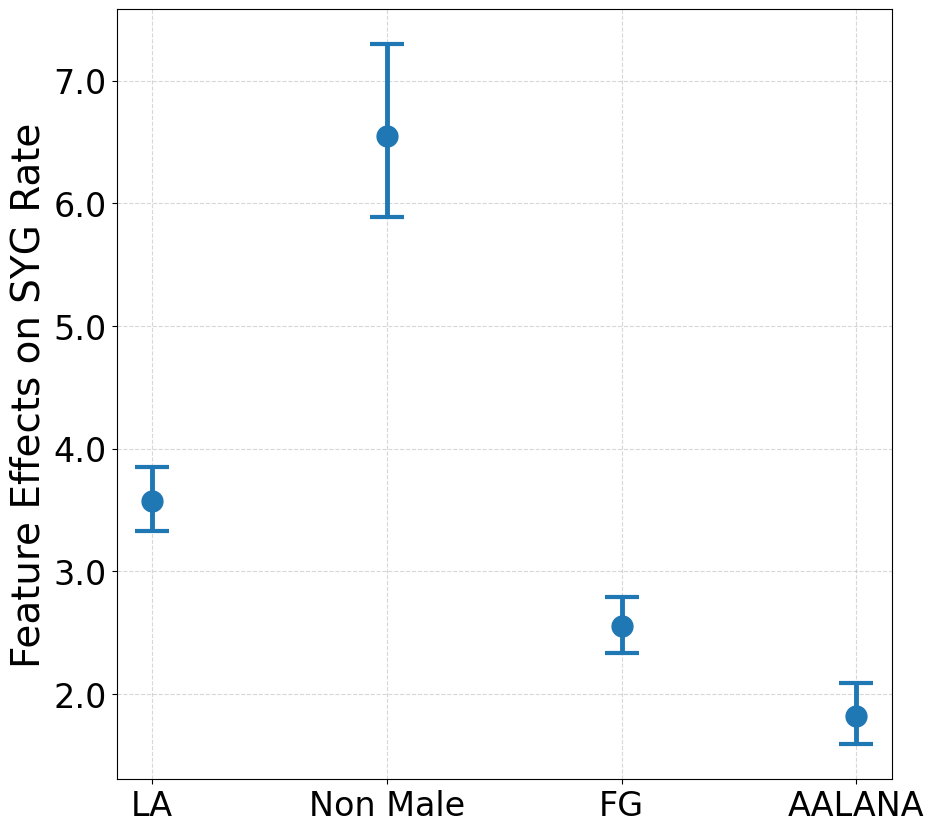

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data (replace this with your data)
exp_coefficients_SYG = np.exp(log_reg_With_SYG.params)
coefficients_SYG = log_reg_With_SYG.params.values
std_errors_SYG = log_reg_With_SYG.bse.values

# Calculate upper and lower bounds of error bars for SYG model
error_range_SYG = np.exp(std_errors_SYG)  # raise to the power of e
upper_bound_SYG = np.exp(coefficients_SYG + std_errors_SYG)
lower_bound_SYG = np.exp(coefficients_SYG - std_errors_SYG)

# Features (replace this with your feature names)
features = ['LA', 'Non Male', 'FG', 'AALANA']

# Create a scatter plot with error bars
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust width and height as needed

# Plot coefficient values as dots
dots = ax.errorbar(np.arange(len(features)), exp_coefficients_SYG, yerr=[exp_coefficients_SYG - lower_bound_SYG, upper_bound_SYG - exp_coefficients_SYG], fmt='o', markersize=15, color='tab:blue', ecolor='tab:blue', capsize=12, capthick=3, linewidth=3.5)  # Adjust capthick here

# Customize the plot
# ax.set_title('SYG Odds for UP1&2', fontsize=28)
ax.set_xlabel('')
ax.set_ylabel('Feature Effects on SYG Rate', fontsize=28)
ax.set_xticks(np.arange(len(features)))
ax.set_xticklabels(features, fontsize=24)

# Increase y-axis label font size
ax.yaxis.set_tick_params(labelsize=24)

# Add grid to the background
ax.grid(True, which='both', linestyle='--', alpha=0.5)

# Set y-axis tick label format to include one decimal place
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.1f}'.format(x)))

# Show the plot
plt.show()


In [17]:
#What if you just have only AALANA students, and the only feature is LA? And then only non-AALANA students, and the only feature is still LA?




df_With_AALANA1 = df[df['AALANA dummy'] == 1]
df_No_AALANA1 = df[df['AALANA dummy'] == 0]

df_With_AALANA2 = df2[df2['AALANA dummy'] == 1]
df_No_AALANA2 = df2[df2['AALANA dummy'] == 0]


Xtrain_Only_AALANA1 = df_With_AALANA1[['LA']]
Xtrain_No_AALANA1 = df_No_AALANA1[['LA']]

Xtrain_Only_AALANA2 = df_With_AALANA2[['LA']]
Xtrain_No_AALANA2 = df_No_AALANA2[['LA']]


ytrain_Only_AALANA_DFW = df_With_AALANA1['DFW dummy']
ytrain_No_AALANA_DFW = df_No_AALANA1['DFW dummy']
ytrain_Only_AALANA_SYG = df_With_AALANA2['SYG']
ytrain_No_AALANA_SYG = df_No_AALANA2['SYG']


log_reg_Only_AALANA_DFW = sm.Logit(ytrain_Only_AALANA_DFW, Xtrain_Only_AALANA1).fit()
log_reg_No_AALANA_DFW = sm.Logit(ytrain_No_AALANA_DFW, Xtrain_No_AALANA1).fit()




log_reg_Only_AALANA_SYG = sm.Logit(ytrain_Only_AALANA_SYG , Xtrain_Only_AALANA2).fit()
log_reg_No_AALANA_SYG = sm.Logit(ytrain_No_AALANA_SYG, Xtrain_No_AALANA2).fit()

# printing the summary table
print(log_reg_Only_AALANA_DFW.summary())
print(log_reg_No_AALANA_DFW.summary())

print(log_reg_Only_AALANA_SYG.summary())
print(log_reg_No_AALANA_SYG.summary())


Optimization terminated successfully.
         Current function value: 0.660917
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614039
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624382
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607578
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              DFW dummy   No. Observations:                  818
Model:                          Logit   Df Residuals:                      817
Method:                           MLE   Df Model:                            0
Date:                Wed, 24 Jul 2024   Pseudo R-squ.:                -0.01763
Time:                        21:47:50   Log-Likelihood:                -540.63
converged:                       True   LL-Null:                       -531.26
Covariance Type:            nonrobust  

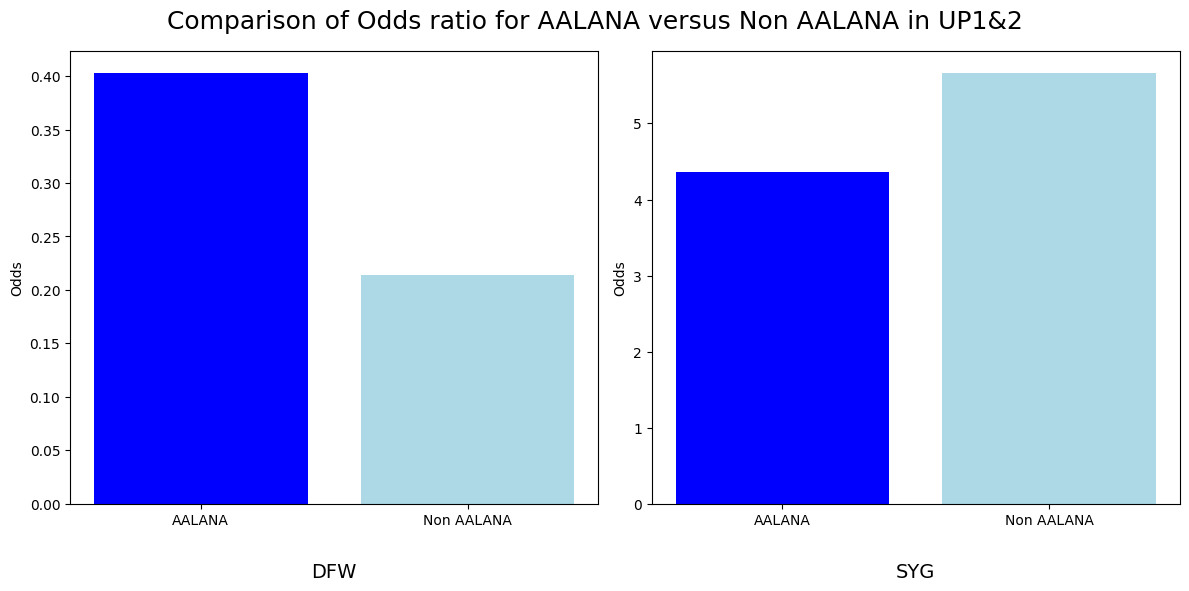

In [18]:
# Extracting the coefficients and their standard errors
coef_dfw_only = log_reg_Only_AALANA_DFW.params['LA']
coef_dfw_no = log_reg_No_AALANA_DFW.params['LA']

coef_syg_only = log_reg_Only_AALANA_SYG.params['LA']
coef_syg_no = log_reg_No_AALANA_SYG.params['LA']

# Calculating the exponentials
exp_coef_dfw_only = np.exp(coef_dfw_only)
exp_coef_dfw_no = np.exp(coef_dfw_no)

exp_coef_syg_only = np.exp(coef_syg_only)
exp_coef_syg_no = np.exp(coef_syg_no)

plt.figure(figsize=(12, 6))

# Histogram for DFW
plt.subplot(1, 2, 1)
plt.bar(['AALANA', 'Non AALANA'], [exp_coef_dfw_only, exp_coef_dfw_no], color=['blue', 'lightblue'])
plt.ylabel('Odds')  # Set the y-label here for the first subplot
plt.text(0.5, -0.15, 'DFW', ha='center', va='center', transform=plt.gca().transAxes, fontsize=14)  # Add 'DFW' under the left subplot

# Histogram for SYG
plt.subplot(1, 2, 2)
plt.bar(['AALANA', 'Non AALANA'], [exp_coef_syg_only, exp_coef_syg_no], color=['blue', 'lightblue'])
plt.ylabel('Odds')  # Set the y-label here for the second subplot
plt.text(0.5, -0.15, 'SYG', ha='center', va='center', transform=plt.gca().transAxes, fontsize=14),  # Add 'SYG' under the right subplot

# Overall title
plt.suptitle('Comparison of Odds ratio for AALANA versus Non AALANA in UP1&2', fontsize=18)

# Show the plot
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

In [19]:
#What if you just have only AALANA students, and the only feature is LA? And then only non-AALANA students, and the only feature is still LA?

df_FG = df[df['First Gen dummy'] == 1]
df_CG = df[df['First Gen dummy'] == 0]


df_FG = df2[df2['First Gen dummy'] == 1]
df_CG = df2[df2['First Gen dummy'] == 0]


Xtrain_FG = df_FG[['LA']]
Xtrain_CG = df_CG[['LA']]
ytrain_FG_DFW = df_FG['DFW dummy']
ytrain_CG_DFW = df_CG['DFW dummy']
ytrain_FG_SYG = df_FG['SYG']
ytrain_CG_SYG = df_CG['SYG']


log_reg_FG_DFW = sm.Logit(ytrain_FG_DFW, Xtrain_FG).fit()
log_reg_CG_DFW = sm.Logit(ytrain_CG_DFW, Xtrain_CG).fit()




log_reg_Only_FG_SYG = sm.Logit(ytrain_FG_SYG, Xtrain_FG).fit()
log_reg_CG_SYG = sm.Logit(ytrain_CG_SYG, Xtrain_CG).fit()

# printing the summary table
print(log_reg_FG_DFW.summary())
print(log_reg_CG_DFW.summary())

print(log_reg_Only_FG_SYG.summary())
print(log_reg_CG_SYG.summary())

Optimization terminated successfully.
         Current function value: 0.625723
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631089
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614830
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607608
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              DFW dummy   No. Observations:                  985
Model:                          Logit   Df Residuals:                      984
Method:                           MLE   Df Model:                            0
Date:                Wed, 24 Jul 2024   Pseudo R-squ.:                -0.08415
Time:                        21:47:58   Log-Likelihood:                -616.34
converged:                       True   LL-Null:                       -568.50
Covariance Type:            nonrobust  

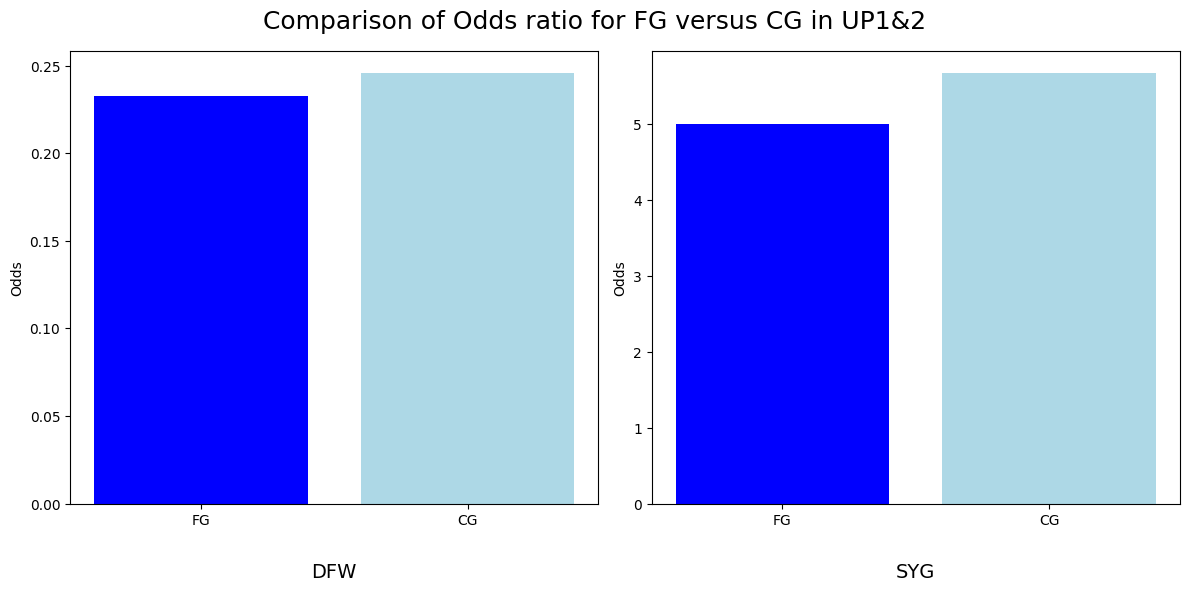

In [20]:
# Extracting the coefficients and their standard errors
coef_dfw_fg = log_reg_FG_DFW.params['LA']
coef_dfw_cg = log_reg_CG_DFW.params['LA']

coef_syg_fg = log_reg_Only_FG_SYG.params['LA']
coef_syg_cg = log_reg_CG_SYG.params['LA']

# Calculating the exponentials
exp_coef_dfw_fg = np.exp(coef_dfw_fg)
exp_coef_dfw_cg = np.exp(coef_dfw_cg)

exp_coef_syg_fg = np.exp(coef_syg_fg)
exp_coef_syg_cg = np.exp(coef_syg_cg)

# Creating histograms
plt.figure(figsize=(12, 6))

# Histogram for DFW
plt.subplot(1, 2, 1)
plt.bar(['FG', 'CG'], [exp_coef_dfw_fg, exp_coef_dfw_cg], color=['blue', 'lightblue'])

plt.ylabel('Odds')  # Set the y-label here for the first subplot
plt.text(0.5, -0.15, 'DFW', ha='center', va='center', transform=plt.gca().transAxes, fontsize=14),  # Add 'SYG' under the right subplot

# Histogram for SYG
plt.subplot(1, 2, 2)
plt.bar(['FG', 'CG'], [exp_coef_syg_fg, exp_coef_syg_cg], color=['blue', 'lightblue'])

plt.ylabel('Odds')  # Set the y-label here for the second subplot
plt.text(0.5, -0.15, 'SYG', ha='center', va='center', transform=plt.gca().transAxes, fontsize=14),  # Add 'SYG' under the right subplot

# Overall title
plt.suptitle('Comparison of Odds ratio for FG versus CG in UP1&2', fontsize=18)

# Show the plot
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

In [24]:
#What if you just have only AALANA students, and the only feature is LA? And then only non-AALANA students, and the only feature is still LA?

Xtrain_AALANA1 = df[['AALANA with LA', 'AALANA with no LA', 'Non-AALANA with LA', 'AALANA with LA Count', 'Non-AALANA with LA Count']]
Xtrain_AALANA2 = df2[['AALANA with LA', 'AALANA with no LA', 'Non-AALANA with LA']]
ytrain_AALANA_DFW = df['DFW dummy']
ytrain_AALANA_SYG = df2['SYG']

log_reg_AALANA_DFW = sm.Logit(ytrain_AALANA_DFW, Xtrain_AALANA1).fit()
print(log_reg_AALANA_DFW.summary())


log_reg_AALANA_SYG = sm.Logit(ytrain_AALANA_SYG, Xtrain_AALANA2).fit()
print(log_reg_AALANA_SYG.summary())




#double checking the values counts For the different AALANA groups
# print(df['AALANA with LA'].value_counts())
# print(df['AALANA with LA Count'].value_counts())
# print(df['AALANA with no LA'].value_counts())
# print(df['AALANA with no LA Count'].value_counts())
# print(df['Non-AALANA with LA'].value_counts())
# print(df['Non-AALANA with LA Count'].value_counts())
# print(df['Non-AALANA with no LA'].value_counts())
# print(df['Non-AALANA with no LA Count'].value_counts())



Optimization terminated successfully.
         Current function value: 0.615716
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:              DFW dummy   No. Observations:                 8941
Model:                          Logit   Df Residuals:                     8936
Method:                           MLE   Df Model:                            4
Date:                Wed, 24 Jul 2024   Pseudo R-squ.:                 -0.1351
Time:                        21:51:36   Log-Likelihood:                -5505.1
converged:                       True   LL-Null:                       -4850.0
Covariance Type:            nonrobust   LLR p-value:                     1.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
AALANA with LA              -0.8355      0.143     -5.845      0.000      -1.116

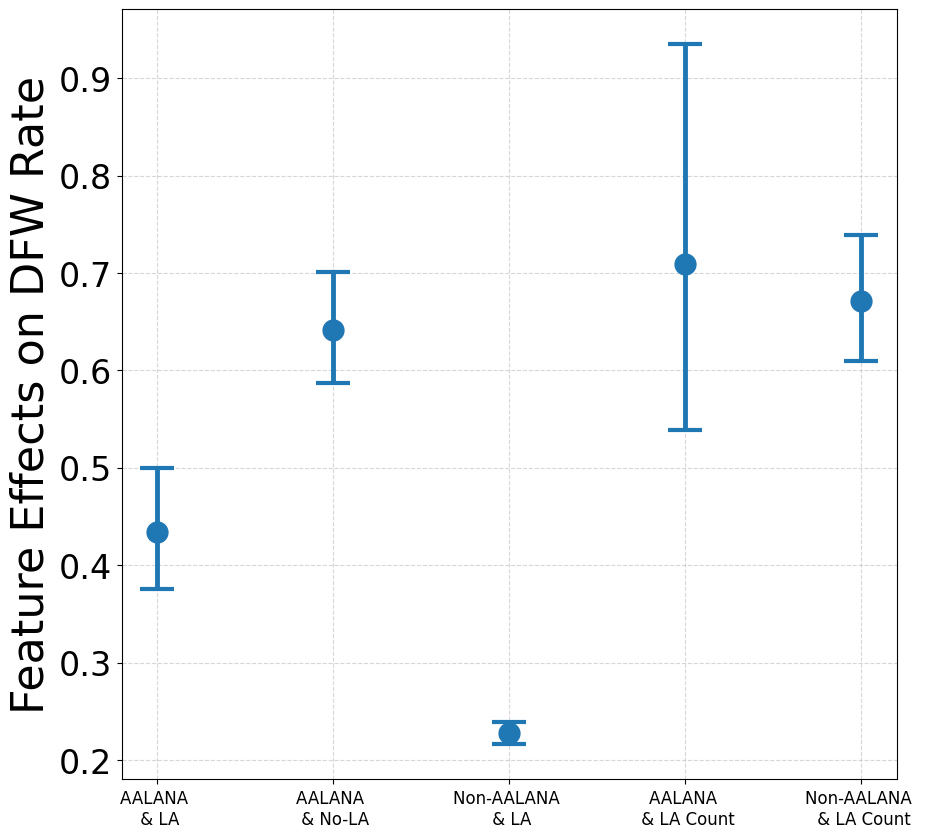

In [25]:

# Sample data (replace this with your data)
exp_coefficients_AALANA_DFW = np.exp(log_reg_AALANA_DFW.params)
coefficients_AALANA_DFW = log_reg_AALANA_DFW.params.values
std_errors_AALANA_DFW = log_reg_AALANA_DFW.bse.values

# Calculate upper and lower bounds of error bars for AALANA_DFW model
error_range_AALANA_DFW = np.exp(std_errors_AALANA_DFW)  # raise to the power of e
upper_bound_AALANA_DFW = np.exp(coefficients_AALANA_DFW + std_errors_AALANA_DFW)
lower_bound_AALANA_DFW = np.exp(coefficients_AALANA_DFW - std_errors_AALANA_DFW)

# Features (replace this with your feature names)
features = ['AALANA \n & LA', 'AALANA \n & No-LA', 'Non-AALANA \n & LA', 'AALANA \n & LA Count', 'Non-AALANA \n & LA Count']

# Create a scatter plot with error bars
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust width and height as needed

# Plot coefficient values as dots
dots = ax.errorbar(np.arange(len(features)), exp_coefficients_AALANA_DFW, yerr=[exp_coefficients_AALANA_DFW - lower_bound_AALANA_DFW, upper_bound_AALANA_DFW - exp_coefficients_AALANA_DFW], fmt='o', markersize=15, color='tab:blue', ecolor='tab:blue', capsize=12, capthick=3, linewidth=3.5)  # Adjust capthick here

# Customize the plot
# ax.set_title('DFW Odds for AALANA Students', fontsize=35)
ax.set_xlabel('')
ax.set_ylabel('Feature Effects on DFW Rate', fontsize=32)
ax.set_xticks(np.arange(len(features)))
ax.set_xticklabels(features, fontsize=12)

# Increase y-axis label font size
ax.yaxis.set_tick_params(labelsize=24)

# Add grid to the background
ax.grid(True, which='both', linestyle='--', alpha=0.5)

# Show the plot
plt.show()



In [27]:
exp_coefficients_AALANA_DFW

AALANA with LA              0.433671
AALANA with no LA           0.641568
Non-AALANA with LA          0.227493
AALANA with LA Count        0.709408
Non-AALANA with LA Count    0.671006
dtype: float64

In [ ]:
exp_coefficients_AALANA_DFW = np.exp(log_reg_AALANA_DFW.params)

print(exp_coefficients_AALANA_DFW)



print(exp_coefficients_AALANA_DFW[0]/exp_coefficients_AALANA_DFW[2])
#



print(exp_coefficients_AALANA_DFW[1])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data (replace this with your data)
exp_coefficients_AALANA_SYG = np.exp(log_reg_AALANA_SYG.params)
coefficients_AALANA_SYG = log_reg_AALANA_SYG.params.values
std_errors_AALANA_SYG = log_reg_AALANA_SYG.bse.values

# Calculate upper and lower bounds of error bars for AALANA_SYG model
error_range_AALANA_SYG = np.exp(std_errors_AALANA_SYG)  # raise to the power of e
upper_bound_AALANA_SYG = np.exp(coefficients_AALANA_SYG + std_errors_AALANA_SYG)
lower_bound_AALANA_SYG = np.exp(coefficients_AALANA_SYG - std_errors_AALANA_SYG)

# Features (replace this with your feature names)
features = ['AALANA \n & LA', 'AALANA \n & No-LA', 'Non-AALANA \n & LA']

# Create a scatter plot with error bars
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust width and height as needed

# Plot coefficient values as dots
dots = ax.errorbar(np.arange(len(features)), exp_coefficients_AALANA_SYG, yerr=[exp_coefficients_AALANA_SYG - lower_bound_AALANA_SYG, upper_bound_AALANA_SYG - exp_coefficients_AALANA_SYG], fmt='o', markersize=15, color='tab:blue', ecolor='tab:blue', capsize=12, capthick=3, linewidth=3.5)  # Adjust capthick here

# Customize the plot
# ax.set_title('SYG Odds for AALANA Students', fontsize=35)
ax.set_xlabel('')
ax.set_ylabel('Feature Effects on SYG Rate', fontsize=32)
ax.set_xticks(np.arange(len(features)))
ax.set_xticklabels(features, fontsize=18)

# Increase y-axis label font size
ax.yaxis.set_tick_params(labelsize=24)

# Add grid to the background
ax.grid(True, which='both', linestyle='--', alpha=0.5)

# Show the plot
plt.show()


In [ ]:
# # Calculate overall percentages
# overall_with_LA = len(df_UP1[df_UP1['LA'] == 1]) / len(df_UP1)
# overall_without_LA = len(df_UP1[df_UP1['LA'] == 0]) / len(df_UP1)

# # Define the calculations for specific groups
# male_with_LA = len(df_UP1[(df_UP1['gender dummy'] == 0) & (df_UP1['LA'] == 1)]) / len(df_UP1)
# male_without_LA = len(df_UP1[(df_UP1['gender dummy'] == 0) & (df_UP1['LA'] == 0)]) / len(df_UP1)

# female_with_LA = len(df_UP1[(df_UP1['gender dummy'] == 1) & (df_UP1['LA'] == 1)]) / len(df_UP1)
# female_without_LA = len(df_UP1[(df_UP1['gender dummy'] == 1) & (df_UP1['LA'] == 0)]) / len(df_UP1)

# CG_with_LA = len(df_UP1[(df_UP1['First Gen dummy'] == 0) & (df_UP1['LA'] == 1)]) / len(df_UP1)
# CG_without_LA = len(df_UP1[(df_UP1['First Gen dummy'] == 0) & (df_UP1['LA'] == 0)]) / len(df_UP1)

# FG_with_LA = len(df_UP1[(df_UP1['First Gen dummy'] == 1) & (df_UP1['LA'] == 1)]) / len(df_UP1)
# FG_without_LA = len(df_UP1[(df_UP1['First Gen dummy'] == 1) & (df_UP1['LA'] == 0)]) / len(df_UP1)

# non_AALANA_with_LA = len(df_UP1[(df_UP1['AALANA dummy'] == 0) & (df_UP1['LA'] == 1)]) / len(df_UP1)
# non_AALANA_without_LA = len(df_UP1[(df_UP1['AALANA dummy'] == 0) & (df_UP1['LA'] == 0)]) / len(df_UP1)

# AALANA_with_LA = len(df_UP1[(df_UP1['AALANA dummy'] == 1) & (df_UP1['LA'] == 1)]) / len(df_UP1)
# AALANA_without_LA = len(df_UP1[(df_UP1['AALANA dummy'] == 1) & (df_UP1['LA'] == 0)]) / len(df_UP1)

# # Plotting the histogram
# labels = ['Overall', 'Overall without LA',
#           'Male', 'Male without LA',
#           'Non Male', 'Non Male without LA',
#           'CG', 'CG without LA',
#           'FG', 'FG without LA',
#           'Non AALANA', 'Non AALANA without LA',
#           'AALANA', 'AALANA without LA']

# values = [overall_with_LA, overall_without_LA,
#           male_with_LA, male_without_LA,
#           female_with_LA, female_without_LA,
#           CG_with_LA, CG_without_LA,
#           FG_with_LA, FG_without_LA,
#           non_AALANA_with_LA, non_AALANA_without_LA,
#           AALANA_with_LA, AALANA_without_LA]

# # Plotting the grouped bar chart
# width = 0.35  # Width of the bars

# # Define colors for "with LA" and "without LA" bars
# colors_with_LA = ['blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue']
# colors_without_LA = ['lightsteelblue', 'lightsteelblue', 'lightsteelblue', 'lightsteelblue', 'lightsteelblue', 'lightsteelblue', 'lightsteelblue']

# # Create an array of indices for each group
# indices = np.arange(len(labels) // 2)

# # Plot "with LA" bars
# plt.bar(indices, values[::2], width=width, label='With LA', color=colors_with_LA)

# # Plot "without LA" bars stacked on top of "with LA" bars
# plt.bar(indices, values[1::2], width=width, bottom=values[::2], label='Without LA', color=colors_without_LA)

# #plt.xlabel('University Physics 1 and 2')
# plt.ylabel('Percentage')
# #plt.title('Students with and without LA by Demographics')

# plt.title('University Physics 1 students from 2013-2022')

# plt.ylim(0, 1)  # Set y-axis limit to [0, 1]

# plt.xticks(indices, labels[::2], rotation=45, ha='right')  # Set x-axis labels and rotate for better readability

# plt.legend(loc='upper center')  # Move legend to the upper left

# plt.tight_layout()
# plt.show()


In [ ]:
def sigm(z):
    return 1 / (1 + np.exp(-z))

def plot_model(b0, b1):

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))

    x = np.linspace(-20, 20, 200)
    p = sigm(b0 + b1 * x)

    line, = ax.plot(x, p, color="steelblue", lw=3)

    # Set the grid
    ax.grid(True, which='both', linestyle='--', alpha=0.5)

    ax.set_xlim([-10, 10])
    ax.set_ylabel('DFW Odds Ratio', fontsize=25)
    ax.legend([line], [r'$p(\overrightarrow{x}) = \frac{1} {1 + e^{-(\beta_0+x_{LA}\beta_1+x_{NonMale}\beta_2+x_{FG}\beta_3+x_{AALANA}\beta_4)}}$'], fontsize=24.5)

    ax.set_yticks([0.0, 0.25, 0.5, 0.75, 1.0])
    ax.tick_params(axis='y', which='major', labelsize=18)

    # Suppress tick marks for the x-axis
    ax.set_xticks([])

    # Suppress tick marks for the y-axis
    #ax.set_yticks([])

    plt.show()


In [ ]:
  plot_model(-1.3, -0.34)